If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers as well as some other libraries. Uncomment the following cell and run it.

In [ ]:
# Install
!pip install -q biopython transformers datasets huggingface_hub accelerate peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to login to the huggingface hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Then you need to install Git-LFS. Uncomment the following instructions:

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("nucleotide_transformer_dna_sequence_modeling_with_lora_notebook", framework="pytorch")

# **Fine-Tuning the Nucleotide-transformer with LoRA**

The **Nucleotide Transformer** paper [Dalla-torre et al, 2023](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v2) introduces 4 genomics foundational models developed by **InstaDeep**. These transformers, of various sizes and trained on different datasets, allow powerful representations of DNA sequences that allow to tackle a very diverse set of problems such as chromatin accessibility, deleteriousness prediction, promoter and enhancer prediction etc... These representations can be extracted from the transformer and used as proxies of the DNA sequences (this is called probing) or the transformer can be trained further on a specific task (this is called finetuning).

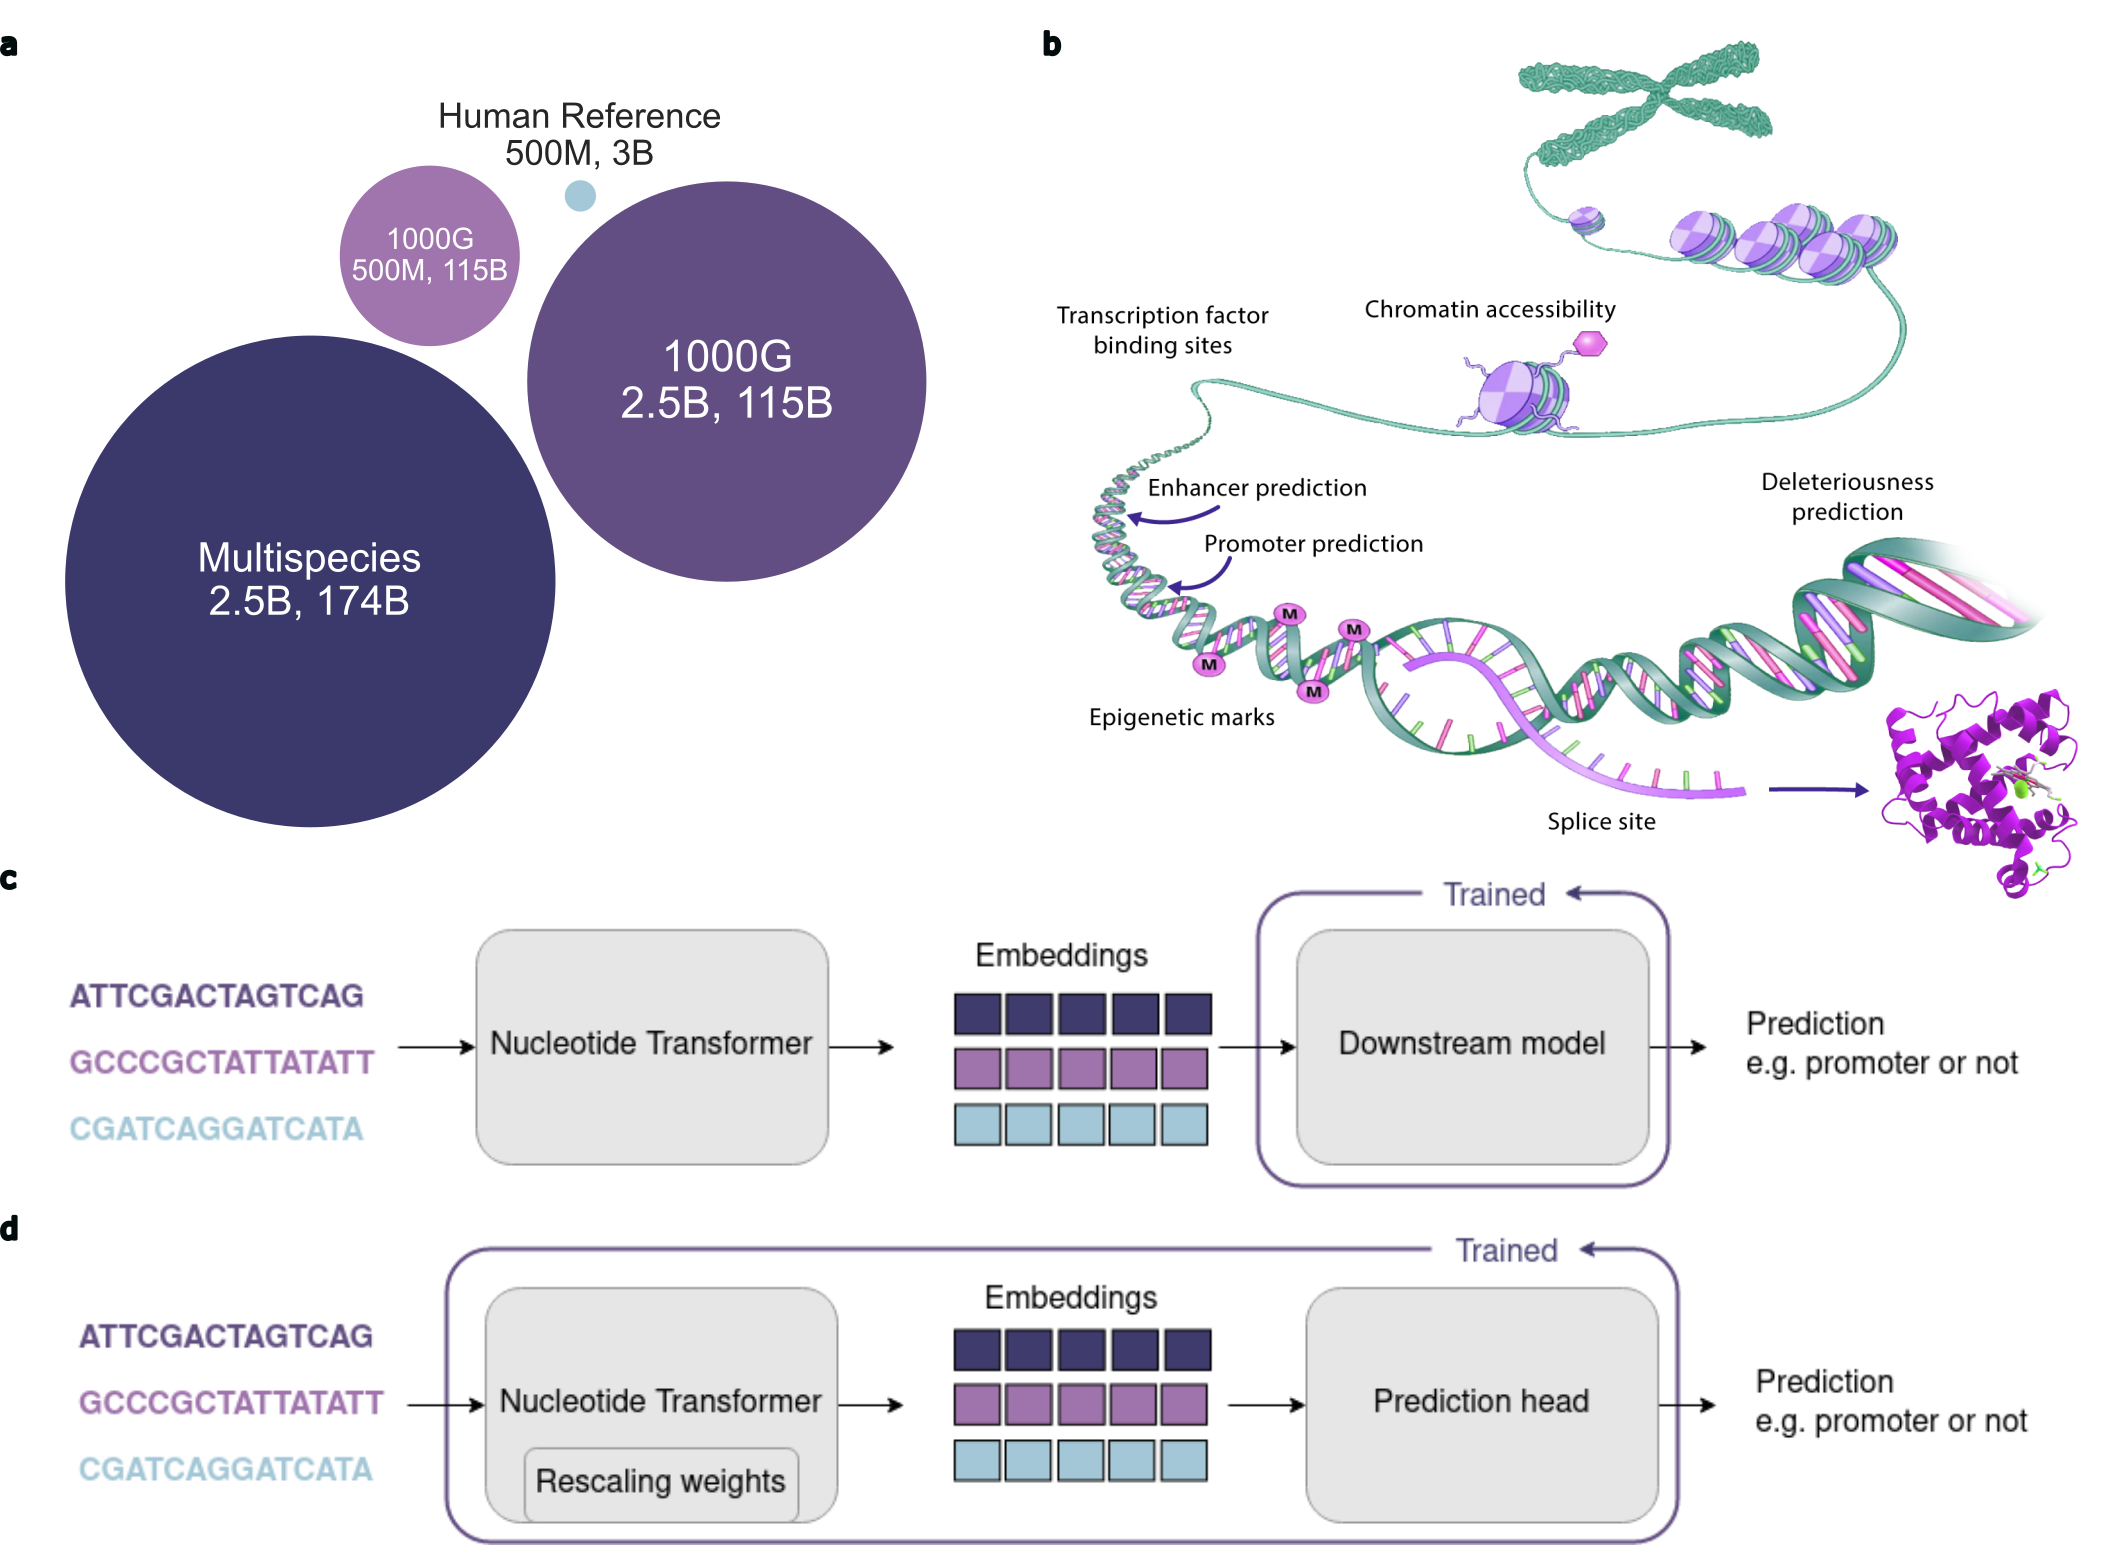

This notebook allows you to fine-tune one of these models.

[LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685) is one of the state of the art parameter-efficient finetuning methods that is explained in details in this [blog post](https://huggingface.co/blog/lora). Any transformer model can be finetuned using this method with very little effort using the 🤗 Transformers library, which is why it is used in this notebook instead of the [IA³ technique](https://arxiv.org/abs/2205.05638) presented in the original paper.

The model we are going to use is the [500M Human Ref model](https://huggingface.co/InstaDeepAI/nucleotide-transformer-500m-1000g), which is a 500M parameters transformer pre-trained on the human reference genome, per the training methodology presented in the Nucleotide Transformer Paper. It is one of the 4 models introduced, all available on the [Instadeep HuggingFace page](https://huggingface.co/InstaDeepAI):

```
| Model name          | Num layers | Num parameters | Training dataset       |
|---------------------|------------|----------------|------------------------|
| `500M Human Ref`    | 24         | 500M           | Human reference genome |
| `500M 1000G`        | 24         | 500M           | 1000G genomes          |
| `2.5B 1000G`        | 32         | 2.5B           | 1000G genomes          |
| `2.5B Multispecies` | 32         | 2.5B           | Multi-species dataset  |

```

Note that even though the finetuning is done with a parameter-efficient method, using the larger checkpoints will still require more GPU memory and produce longer finetuning times

In the following, we showcase the nucleotide transformer ability to classify genomic sequences as two of the most basic genomic motifs: **promoters** and **enhancers types**. Both of them are classification task, but the enhancers types task is much more challenging with its 3 classes.

These two tasks are very basic, but the nucleotide transformers have been shown to beat/match state of the art models on much more complex tasks such as [DeepSEA](https://www.nature.com/articles/nmeth.3547), which, given a DNA sequence, predicts  919 chromatin profiles from a diverse set of human cells and tissues from a single sequence or [DeepSTARR](https://www.nature.com/articles/s41588-022-01048-5), which predicts an enhancer's activity.


## **Importing required packages and setting up PEFT model**

### **Import and install**

In [ ]:
# Imports
from transformers import AutoTokenizer, AutoModelForMaskedLM, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()

### **Prepare and create the model for fine-tuning**

The nucleotide transformer will be fine-tuned on two **classification tasks**: promoter and enhancer types classification.
The `AutoModelForSequenceClassification` module automatically loads the model and adds a simple classification head on top of the final embeddings.

In [ ]:
num_labels_promoter = 2
# Load the model
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref", num_labels=num_labels_promoter)
model = model.to(device)

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref were not used when initializing EsmForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['classifier.out_proj.bias', 'classifier

The LoRA parameters are now added to the model, and the parameters that will be finetuned are indicated.

In [ ]:
from peft import LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=1, lora_alpha= 32, lora_dropout=0.1, target_modules= ["query", "value"],
    #modules_to_save=["intermediate"] # modules that are not frozen and updated during the training
)

In [ ]:
from peft import get_peft_model

lora_classifier = get_peft_model(model, peft_config) # transform our classifier into a peft model
lora_classifier.print_trainable_parameters()
lora_classifier.to(device) # Put the model on the GPU

trainable params: 3407364 || all params: 482205925 || trainable%: 0.7066201021897439


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(4105, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1002, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-23): 24 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): Linear(
                    in_features=1280, out_features=1280, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1280, out_features=1, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default

## **First task : Promoter prediction**

Promoter prediction is a **sequence classification** problem, in which the DNA sequence is predicted to be either a promoter or not.

A promoter is a region of DNA where transcription of a gene is initiated. Promoters are a vital component of expression vectors because they control the binding of RNA polymerase to DNA. RNA polymerase transcribes DNA to mRNA which is ultimately translated into a functional protein

 This task was introduced in [DeePromoter](https://www.frontiersin.org/articles/10.3389/fgene.2019.00286/full), where a set of TATA and non-TATA promoters was gathered. A negative sequence was generated from each promoter, by randomly sampling subsets of the sequence, to guarantee that some obvious motifs were present both in the positive and negative dataset.



### **Dataset loading and preparation**

In [ ]:
from datasets import load_dataset, Dataset

# Load the promoter dataset from the InstaDeep Hugging Face ressources
dataset_name = "promoter_all"
train_dataset_promoter = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks",
        dataset_name,
        split="train",
        streaming= False,
    )
test_dataset_promoter = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks",
        dataset_name,
        split="test",
        streaming= False,
    )

In [ ]:
# Get training data
train_sequences_promoter = train_dataset_promoter['sequence']
train_labels_promoter = train_dataset_promoter['label']

# Split the dataset into a training and a validation dataset
train_sequences_promoter, validation_sequences_promoter, train_labels_promoter, validation_labels_promoter = train_test_split(train_sequences_promoter,
                                                                              train_labels_promoter, test_size=0.05, random_state=42)

# Get test data
test_sequences_promoter = test_dataset_promoter['sequence']
test_labels_promoter = test_dataset_promoter['label']

Let us have a look at the data. If we extract the last sequence of the dataset, we see that it is indeed a promoter, as its label is 1. Furthermore, we can also see that it is a TATA promoter, as the TATA motif is present at the 221th nucleotide of the sequence!

In [ ]:
idx_sequence = -1
sequence, label = train_sequences_promoter[idx_sequence], train_labels_promoter[idx_sequence]
print(f"The DNA sequence is {sequence}.")
print(f"Its associated label is label {label}.")

idx_TATA = sequence.find("TATA")

print(f"This promoter is a TATA promoter, as the TATA motif is present at the {idx_TATA}th nucleotide.")

The DNA sequence is CACACCAGACAAAATTTGGTTAATTTGCGCCCAATATTCATTACTTTGACCTAACCTTTGTTCTGAAGGCCGTGTACAAGGACAAGGCCCTGAGATTATTGCAACAGTAACTTGAAAAACTTTCAGAAGTCTATTCTGTAGGATTAAAGGAATGCTGAGACTATTCAAGTTTGAAGTCCTGGGGGTGGGGAAAAATAAAAAACCTGTGCTAGAAAGCTTAGTATAGCATGTAACTTTAGAGTCCTGTGGAGTCCTGAGTCTCCCACAGACCAGAACAGTCATTTAAAAGTTTTCAGGAAA.
Its associated label is label 1.
This promoter is a TATA promoter, as the TATA motif is present at the 221th nucleotide.


### **Tokenizing the datasets**

All inputs to neural nets must be numerical. The process of converting strings into numerical indices suitable for a neural net is called **tokenization**.

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")

In [ ]:
# Promoter dataset
ds_train_promoter = Dataset.from_dict({"data": train_sequences_promoter,'labels':train_labels_promoter})
ds_validation_promoter = Dataset.from_dict({"data": validation_sequences_promoter,'labels':validation_labels_promoter})
ds_test_promoter = Dataset.from_dict({"data": test_sequences_promoter,'labels':test_labels_promoter})

In [ ]:
def tokenize_function(examples):
    outputs = tokenizer(examples["data"])
    return outputs

In [ ]:
# Creating tokenized promoter dataset
tokenized_datasets_train_promoter = ds_train_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_validation_promoter = ds_validation_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_test_promoter = ds_test_promoter.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map:   0%|          | 0/50612 [00:00<?, ? examples/s]

Map:   0%|          | 0/2664 [00:00<?, ? examples/s]

Map:   0%|          | 0/5920 [00:00<?, ? examples/s]

### **Fine-tuning and evaluation**

We initialize our `TrainingArguments`. These control the various training hyperparameters, and will be passed to our `Trainer`.

The hyperparameters used for the IA³ method in the paper do not provide good performance for the LoRa method. Mainly, LoRA introduces more trainable parameters, therefore requiring a smaller learning rate. We here use a learning rate of 5.10⁻⁴, which enables us to get close to the [**paper's**](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1.full.pdf) performance.


In [ ]:
batch_size = 8
model_name='nucleotide-transformer'
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-lora-NucleotideTransformer",
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="f1_score",
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps= 1000
)

Next, we define the metric we will use to evaluate our models and write a `compute_metrics` function. We can load this from the `scikit-learn` library.

In [ ]:
# Define the metric for the evaluation using the f1 score
def compute_metrics_f1_score(eval_pred):
    """Computes F1 score for binary classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    r={'f1_score': f1_score(references, predictions)}
    return r

In [ ]:
trainer = Trainer(
    model.to(device),
    args_promoter,
    train_dataset= tokenized_datasets_train_promoter,
    eval_dataset= tokenized_datasets_validation_promoter,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_f1_score,
)

We can now finetune our model by just calling the `train` method:

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Score
50,0.694300,0.303063,0.868529
100,0.428800,0.339864,0.860425
150,0.316200,0.319432,0.882127
200,0.323000,0.801778,0.835847
250,0.511100,0.345184,0.883108
300,0.339200,0.229713,0.917197
350,0.379100,0.185076,0.928080
400,0.278600,0.300546,0.903745
450,0.315800,0.385970,0.865659
500,0.356600,0.183107,0.940402


Note that the finetuning is done with a small batch size (8). The training time can be reduced by increasing the batch size, as it leverages parallelism in the GPU.

#### **Validation F1 score**

In [ ]:
curve_evaluation_f1_score =[[a['step'],a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a.keys()]
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

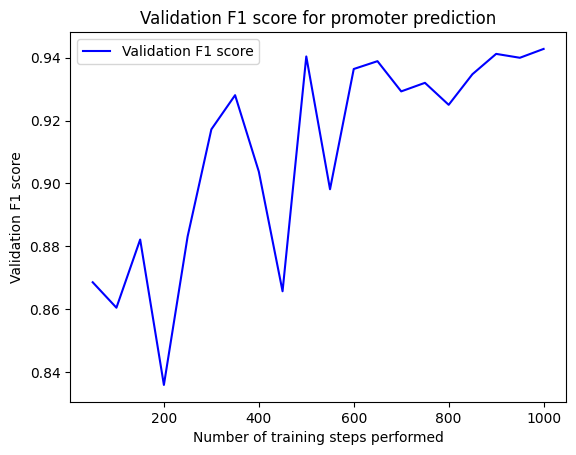

In [ ]:
plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
plt.title('Validation F1 score for promoter prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend()
plt.show()

#### **F1 score on the test dataset**

In [ ]:
# Compute the F1 score on the test dataset :
print(f"F1 score on the test dataset: {trainer.predict(tokenized_datasets_test_promoter).metrics['test_f1_score']}")

F1 score on the test dataset: 0.9370581134678393


For the promoter prediction task, we reproduced the experiment carried out in the [**article**](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1.full.pdf) by adapting the learning rate to the LoRa method. A F1 score of **0.937** is obtained after just **1000 training steps**. To get closer to the **0.954** score obtained in the nucleotide transformer paper after 10,000 training steps, we surely need to train for longer!

## **Second task : Enhancer prediction**

In this section, we fine-tune the nucleotide transformer model on **enhancer type prediction**, which consists in classifying a DNA sequence as **strong**, **weak** or **non enhancer**.

In genetics, an enhancer is a short (50–1500 bp) region of DNA that can be bound by proteins (activators) to increase the likelihood that transcription of a particular gene will occur.

[A deep learning framework for enhancer prediction using word embedding and sequence generation](https://www.sciencedirect.com/science/article/abs/pii/S0301462222000643) introduced the dataset used here by augmenting an original set of enhancers with 6000 synthetic enhancers and 6000 synthetic
non-enhancers produced through a generative model.

### **Dataset loading and preparation**

In [ ]:
from datasets import load_dataset, Dataset

# Load the enhancers dataset from the InstaDeep Hugging Face ressources
dataset_name = "enhancers_types"
train_dataset_enhancers = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks",
        dataset_name,
        split="train",
        streaming= False,
    )
test_dataset_enhancers = load_dataset(
        "InstaDeepAI/nucleotide_transformer_downstream_tasks",
        dataset_name,
        split="test",
        streaming= False,
    )

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset nucleotide_transformer_downstream_tasks downloaded and prepared to /root/.cache/huggingface/datasets/InstaDeepAI___nucleotide_transformer_downstream_tasks/enhancers_types/0.0.0/4a78b0644424e03fb4f26af3966a46e57ea50a1132ab8bb2f63b7808ce6a8772. Subsequent calls will reuse this data.


In [ ]:
# Get training data
train_sequences_enhancers = train_dataset_enhancers['sequence']
train_labels_enhancers = train_dataset_enhancers['label']

# Split the dataset into a training and a validation dataset
train_sequences_enhancers, validation_sequences_enhancers, train_labels_enhancers, validation_labels_enhancers = train_test_split(train_sequences_enhancers,
                                                                              train_labels_enhancers, test_size=0.10, random_state=42)

In [ ]:
# Get test data
test_sequences_enhancers = test_dataset_enhancers['sequence']
test_labels_enhancers = test_dataset_enhancers['label']

### **Tokenizing the datasets**

In [ ]:
# Enhancer dataset
ds_train_enhancers = Dataset.from_dict({"data": train_sequences_enhancers,'labels':train_labels_enhancers})
ds_validation_enhancers = Dataset.from_dict({"data": validation_sequences_enhancers,'labels':validation_labels_enhancers})
ds_test_enhancers = Dataset.from_dict({"data": test_sequences_enhancers,'labels':test_labels_enhancers})

In [ ]:
# Creating tokenized enhancer dataset
tokenized_datasets_train_enhancers = ds_train_enhancers.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_validation_enhancers = ds_validation_enhancers.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)
tokenized_datasets_test_enhancers = ds_test_enhancers.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

Map:   0%|          | 0/13471 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

### **Fine-tuning and evaluation**

In [ ]:
# Load the model
num_labels_enhancers = 3
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref", num_labels=num_labels_enhancers)
model = model.to(device)

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['classifier.out_proj.bias', 'classifier

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=1, lora_alpha= 32, lora_dropout=0.1, target_modules= ["query", "value"],
    #modules_to_save=["intermediate"] # modules that are not frozen and updated during the training
)

In [ ]:
lora_classifier = get_peft_model(model, peft_config) # transform our classifier into a peft model
lora_classifier.print_trainable_parameters()
lora_classifier.to(device) # Put the model on the GPU

trainable params: 3409926 || all params: 482208487 || trainable%: 0.7071476533344383


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(4105, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1002, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-23): 24 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): Linear(
                    in_features=1280, out_features=1280, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1280, out_features=1, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default

We initialize our `TrainingArguments`. These control the various training hyperparameters, and will be passed to our `Trainer`.

We keep the same hyperparameters as for the promoter task, i.e the same as in the paper except for a learning rate of 5.10⁻⁴, which enables us to get close to [**paper's**](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1.full.pdf) performance.

In [ ]:
batch_size = 8
model_name='nucleotide-transformer'
args_enhancers = TrainingArguments(
    f"{model_name}-finetuned-lora-NucleotideTransformer",
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size= 64,
    num_train_epochs= 2,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="mcc_score", # The mcc_score on the evaluation dataset used to select the best model
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps= 1000
)

Here, the metric used to evaluate the model is the Matthews Correlation Coefficient, which is more relevant than the accuracy when the classes in the dataset are unbalanced. We can load a predefined function from the `scikit-learn` library.

In [ ]:
# Define the metric for the evaluation
def compute_metrics_mcc(eval_pred):
    """Computes Matthews correlation coefficient (MCC score) for binary classification"""
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    r={'mcc_score': matthews_corrcoef(references, predictions)}
    return r

In [ ]:
trainer = Trainer(
    lora_classifier,
    args_enhancers,
    train_dataset= tokenized_datasets_train_enhancers,
    eval_dataset= tokenized_datasets_validation_enhancers,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_mcc,
)

We can now finetune our model by just calling the `train` method:

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Mcc Score
100,0.961600,0.726498,0.495365
200,0.833900,0.626991,0.643095
300,0.734600,0.573470,0.694201
400,0.640400,0.630680,0.534824
500,0.591500,0.454023,0.718646
600,0.538900,0.575029,0.690705
700,0.491400,0.417109,0.756448
800,0.424700,0.400224,0.774119
900,0.409500,0.392883,0.774641
1000,0.407800,0.380015,0.781762


As with the first task, the time can be greatly reduced by increasing the batch size.

#### **Validation MCC score**

In [ ]:
curve_evaluation_mcc_score=[[a['step'],a['eval_mcc_score']] for a in trainer.state.log_history if 'eval_mcc_score' in a.keys()]
eval_mcc_score = [c[1] for c in curve_evaluation_mcc_score]
steps = [c[0] for c in curve_evaluation_mcc_score]

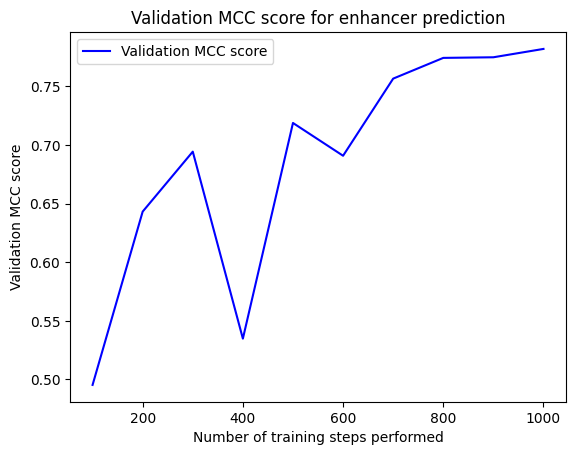

In [ ]:
plt.plot(steps, eval_mcc_score, 'b', label='Validation MCC score')
plt.title('Validation MCC score for enhancer prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation MCC score')
plt.legend()
plt.show()

#### **MCC on the test dataset**

In [ ]:
# Compute the MCC score on the test dataset :
print(f"MCC score on the test dataset: {trainer.predict(tokenized_datasets_test_enhancers).metrics['test_mcc_score']}")

MCC score on the test dataset: 0.3962247896674896


For the enhancers types prediction task, we obtain a perforance after 1000 training steps that is **0.40**, which is already beating the baseline on which Nucleotide Transformer is compared (**0.395**). This is still, however, **8.5** percent points below its performance (**0.485**) in the [Nucleotide Transformers paper](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1.full.pdf). To match the paper results more closely, it will probably be necessary to increase the number of training steps. Also note that the paper used a parameter-efficient finetuning method called IA3, whereas in this notebook we use the LoRA setting, which differs in various manners